<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Introduction" data-toc-modified-id="1-Introduction-1">1 Introduction</a></span></li><li><span><a href="#2-Data-Access" data-toc-modified-id="2-Data-Access-2">2 Data Access</a></span></li><li><span><a href="#3-Boosting" data-toc-modified-id="3-Boosting-3">3 Boosting</a></span><ul class="toc-item"><li><span><a href="#3.1-Shape-classification" data-toc-modified-id="3.1-Shape-classification-3.1">3.1 Shape classification</a></span></li><li><span><a href="#3.2-Plotting-the-shape-classification-results" data-toc-modified-id="3.2-Plotting-the-shape-classification-results-3.2">3.2 Plotting the shape classification results</a></span></li><li><span><a href="#3.3-Intensity-classification" data-toc-modified-id="3.3-Intensity-classification-3.3">3.3 Intensity classification</a></span></li><li><span><a href="#3.4-Plotting-the-intensity-classification-results" data-toc-modified-id="3.4-Plotting-the-intensity-classification-results-3.4">3.4 Plotting the intensity classification results</a></span></li></ul></li><li><span><a href="#4-Optimal-parameters" data-toc-modified-id="4-Optimal-parameters-4">4 Optimal parameters</a></span></li></ul></div>

# 1 Introduction
<br>
The Support Vector Machine Classifier (SVMC) has several inputs, such as the kernel (and its specific parameters) and penalty factor (C). Here, we investigated the optimal kernel and C for training the Optical Water Type (OWT) classification in Sentinel-2 MSI bands. Notice that he bands used are the normalized B2, B3, B4, B5, and B6; also, the no normalized B3 is used in the intensity classification. Those bands were chosen due its performance in satellite images, and also in a boosting process done in my master dissertation.
<img src="00_Database/00_Figures/01_algorithm_flowchart.PNG" style="width:70%">

# 2 Data Access
<br>
Obs.: Notice that the raw dataset is not available because it is not an open source.

In [1]:
# library used
import pandas as pd

# msia Input
insitu_db = pd.read_csv('00_Database/01_Tables/insitu_db.csv', index_col=0)

In [2]:
# define the input data
msi_norm = insitu_db[['normB2', 'normB3', 'normB4', 'normB5','normB6']]
msi_b3 = insitu_db[['B3']]
owts = insitu_db[['OWTs']]
owts_shape = owts.applymap(lambda x: x.replace('OWT 6', 'change').
              replace('OWT 7', 'change').
              replace('OWT 8', 'change').
              replace('change', 'OWT 678'))

In [3]:
# library used
from IPython.core import display as ICD

print('Normalized bands')
ICD.display(msi_norm.head(3))

print('Band B3')
ICD.display(msi_b3.head(3))

print('OWTs')
ICD.display(owts.head(3))

print('OWTs for shape classification')
ICD.display(owts_shape.head(3))

Normalized bands


,normB2,normB3,normB4,normB5,normB6
0,0.146600,0.243643,0.276151,0.247569,0.086037
1,0.157793,0.290937,0.195015,0.274566,0.081689
2,0.159576,0.284865,0.244329,0.236879,0.074350


Band B3


,B3
0,0.016585
1,0.014481
2,0.013910


OWTs


,OWTs
0,OWT 7
1,OWT 3
2,OWT 3


OWTs for shape classification


,OWTs
0,OWT 678
1,OWT 3
2,OWT 3


# 3 Boosting
<br>
In this process, we will vary the C for each kernel in a thousand interactions. Then, we compute the accuracy and balanced accuracy and plot to choses the optimal kernel and C.

## 3.1 Shape classification

In [4]:
# library used
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
import warnings

# ignore warnings (some warnings occurs when the algorithm performance is too low and generates 0 predictions)
warnings.simplefilter('ignore')

# dictionary for saving the results

ba = {} # balanced accuracy
precision = {}
recall = {}

for x in range(1,100): # number of interactions
    
    # splits the ids into a train (70%) and a test (30%) datasets, weighting the relative proportion of OWTs
    train, test = train_test_split(list(owts_shape.index),
                                    test_size=0.3,
                                     stratify=owts_shape['OWTs'])
    

    # defines the true values of the test dataset
    true = owts_shape.loc[test,:]

    # creates the arrays for the SVMC algorithm (shape classification)
    msi_shape_x = msi_norm.loc[train,:].values
    msi_shape_y = list(owts_shape.loc[train,'OWTs'])
    
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']: # the available kernels

        for C in np.arange(1, 120, 5): # range of C
           
            # train the shape classification algorithm
            msi_svmc_shape = svm.SVC(C=C,
                                     kernel=kernel,
                                     decision_function_shape='ovo',
                                     class_weight='balanced',
                                     probability=True).fit(msi_shape_x,
                                                           msi_shape_y)


            # predict the OWTs in the test dataset (shape)
            msi_svmc_predicted = msi_svmc_shape.predict(msi_norm.loc[test,:].values)
            msi_svmc_predicted = pd.DataFrame(msi_svmc_predicted,
                                              index=test,
                                              columns=['msi_predicted'])


            # creates an evaluation dataset, concatenate predicted OWTs and the true OWTs
            msi_evaluation = msi_svmc_predicted.join(true)

            # computes balanced accuracy, precision, and recall
            msi_ba = balanced_accuracy_score(msi_evaluation['OWTs'],
                                             msi_evaluation['msi_predicted'])
            
            msi_report = pd.DataFrame(classification_report(msi_evaluation['OWTs'],
                                                    msi_evaluation['msi_predicted'],
                                                    output_dict=True))
            
            # saves the results
            ba[x, kernel, C] = msi_ba
            precision[x, kernel, C] = msi_report.loc['precision',:]['OWT 1':'OWT 678'].values
            recall[x, kernel, C] = msi_report.loc['recall',:]['OWT 1':'OWT 678'].values
            
# create a dataframe with the results
ba_report = pd.DataFrame(ba.keys(), columns=['x', 'kernel', 'C']).join(pd.DataFrame(ba.values(), columns=['ba']))
precision_report = pd.DataFrame(precision.keys(),
                         columns=['x', 'kernel', 'C']).join(pd.DataFrame(precision.values(),
                                                                         columns=['OWT 1',
                                                                                 'OWT 2',
                                                                                 'OWT 3',
                                                                                 'OWT 4',
                                                                                 'OWT 5',
                                                                                 'OWT 678']))

recall_report = pd.DataFrame(precision.keys(),
                         columns=['x', 'kernel', 'C']).join(pd.DataFrame(recall.values(),
                                                                         columns=['OWT 1',
                                                                                 'OWT 2',
                                                                                 'OWT 3',
                                                                                 'OWT 4',
                                                                                 'OWT 5',
                                                                                 'OWT 678']))

## 3.2 Plotting the shape classification results

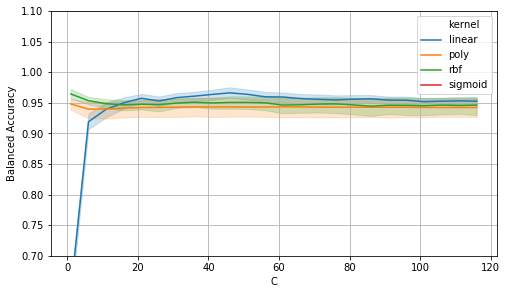

In [5]:
# library used
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4.5))
ax = plt.subplot(1, 1, 1)
sns.lineplot(x='C',
             y='ba',
             hue='kernel',
             data=ba_report,
             ax=ax)
ax.set_ylim(0.7,1.1)
ax.set_ylabel('Balanced Accuracy')
ax.grid()

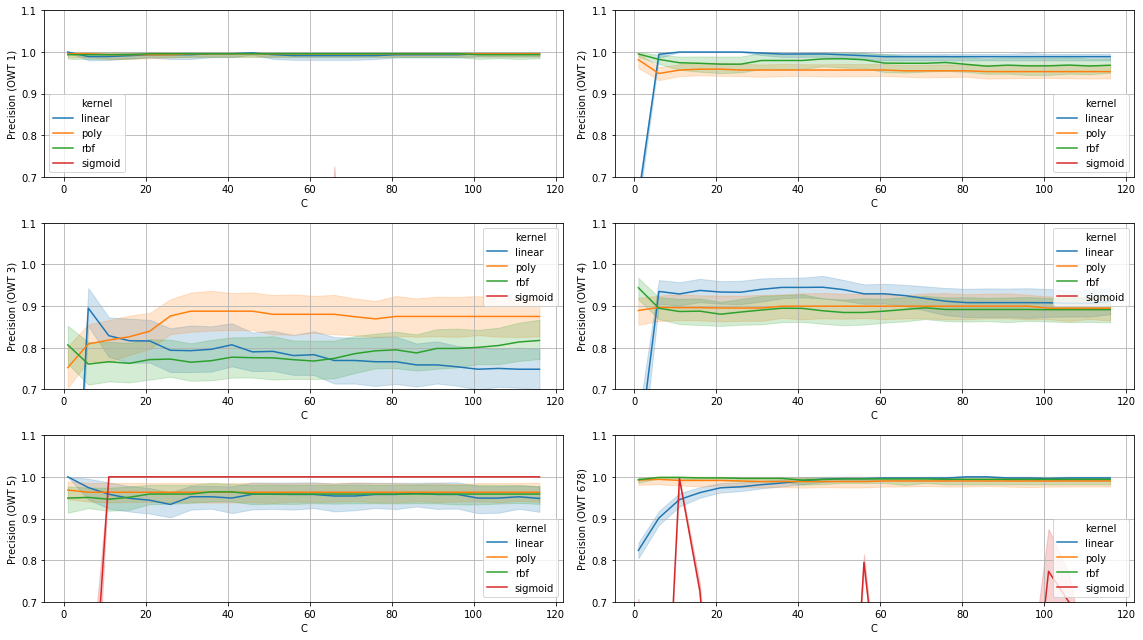

In [6]:
plt.figure(figsize=(16, 9))
i = 1
for x in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4',  'OWT 5', 'OWT 678']:
    ax = plt.subplot(3, 2, i)
    sns.lineplot(x='C',
                 y=x,
                 hue='kernel',
                 data=precision_report,
                 ax=ax)
    ax.set_ylim(0.7,1.1)
    ax.set_ylabel('Precision (' + x + ')')
    ax.grid()
    i = i + 1
    
plt.tight_layout()

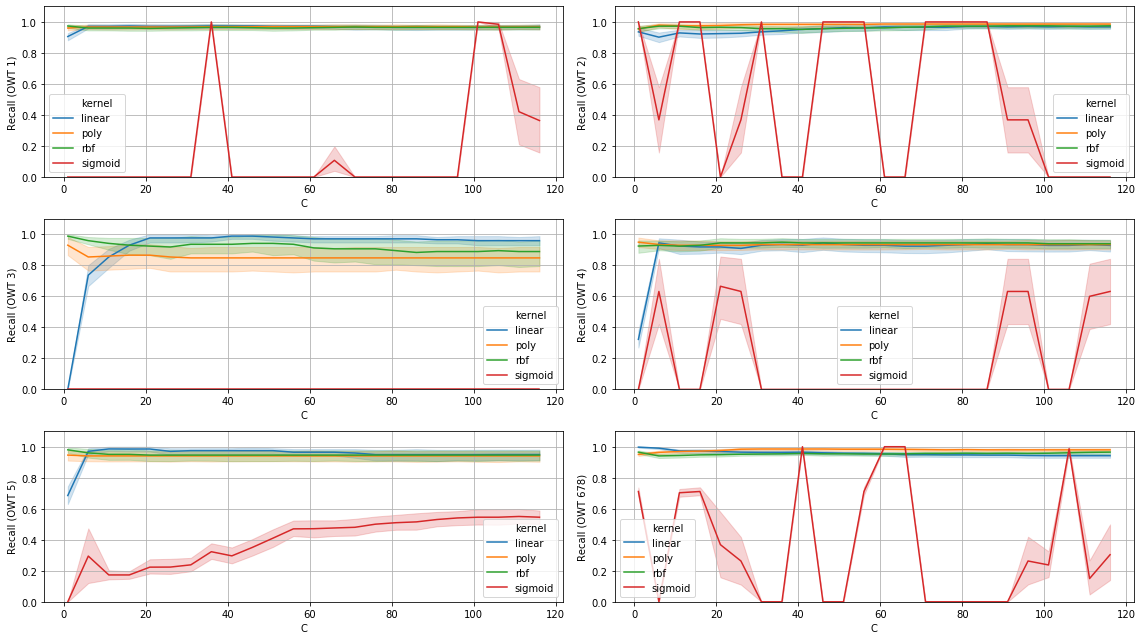

In [7]:
plt.figure(figsize=(16, 9))
i = 1
for x in ['OWT 1', 'OWT 2', 'OWT 3', 'OWT 4',  'OWT 5', 'OWT 678']:
    ax = plt.subplot(3, 2, i)
    sns.lineplot(x='C',
                 y=x,
                 hue='kernel',
                 data=recall_report,
                 ax=ax)
    ax.set_ylim(0,1.1)
    ax.set_ylabel('Recall (' + x + ')')
    ax.grid()
    i = i + 1
    
plt.tight_layout()

## 3.3 Intensity classification

In [8]:
owts678 = owts[(owts['OWTs'] == 'OWT 6') | (owts['OWTs'] == 'OWT 7') | (owts['OWTs'] == 'OWT 8')]

In [9]:
# ignore warnings  (some warnings occurs when the algorithm performance is too low and generates 0 predictions)
warnings.simplefilter('ignore')

# dictionary for saving the results

ba = {} # balanced accuracy
precision = {}
recall = {}

for x in range(1,100): # number of interactions
    
    # splits the ids into a train (70%) and a test (30%) datasets, weighting the relative proportion of OWTs
    train, test = train_test_split(list(owts678.index),
                                    test_size=0.3,
                                     stratify=owts678['OWTs'])
    

    # defines the true values of the test dataset
    true = owts678.loc[test,:]

    # creates the arrays for the SVMC algorithm (shape classification)
    msi_shape_x = msi_b3.loc[train,:].values
    msi_shape_y = list(owts678.loc[train,'OWTs'])
    
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']: # the available kernels

        for C in np.arange(1, 120, 5): # range of C
           
            # train the shape classification algorithm
            msi_svmc_shape = svm.SVC(C=C,
                                     kernel=kernel,
                                     decision_function_shape='ovo',
                                     class_weight='balanced',
                                     probability=True).fit(msi_shape_x,
                                                           msi_shape_y)


            # predict the OWTs in the test dataset (shape)
            msi_svmc_predicted = msi_svmc_shape.predict(msi_b3.loc[test,:].values)
            msi_svmc_predicted = pd.DataFrame(msi_svmc_predicted,
                                              index=test,
                                              columns=['msi_predicted'])


            # creates an evaluation dataset, concatenate predicted OWTs and the true OWTs
            msi_evaluation = msi_svmc_predicted.join(true)

            # computes balanced accuracy, precision, and recall
            msi_ba = balanced_accuracy_score(msi_evaluation['OWTs'],
                                             msi_evaluation['msi_predicted'])
            
            msi_report = pd.DataFrame(classification_report(msi_evaluation['OWTs'],
                                                    msi_evaluation['msi_predicted'],
                                                    output_dict=True))
            
            # saves the results
            ba[x, kernel, C] = msi_ba
            precision[x, kernel, C] = msi_report.loc['precision',:]['OWT 6':'OWT 8'].values
            recall[x, kernel, C] = msi_report.loc['recall',:]['OWT 6':'OWT 8'].values
            
# create a dataframe with the results
ba_report = pd.DataFrame(ba.keys(), columns=['x', 'kernel', 'C']).join(pd.DataFrame(ba.values(), columns=['ba']))
precision_report = pd.DataFrame(precision.keys(),
                         columns=['x', 'kernel', 'C']).join(pd.DataFrame(precision.values(),
                                                                         columns=['OWT 6',
                                                                                 'OWT 7',
                                                                                 'OWT 8']))
recall_report = pd.DataFrame(precision.keys(),
                         columns=['x', 'kernel', 'C']).join(pd.DataFrame(recall.values(),
                                                                         columns=['OWT 6',
                                                                                 'OWT 7',
                                                                                 'OWT 8']))

## 3.4 Plotting the intensity classification results

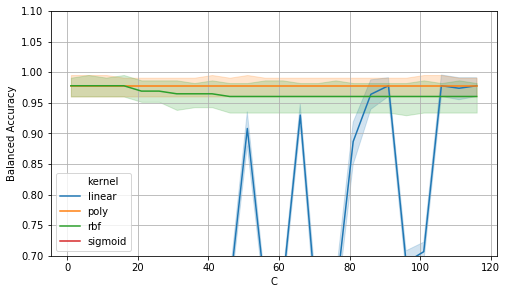

In [10]:
# library used
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4.5))
ax = plt.subplot(1, 1, 1)
sns.lineplot(x='C',
             y='ba',
             hue='kernel',
             data=ba_report,
             ax=ax)
ax.set_ylim(0.7,1.1)
ax.set_ylabel('Balanced Accuracy')
ax.grid()

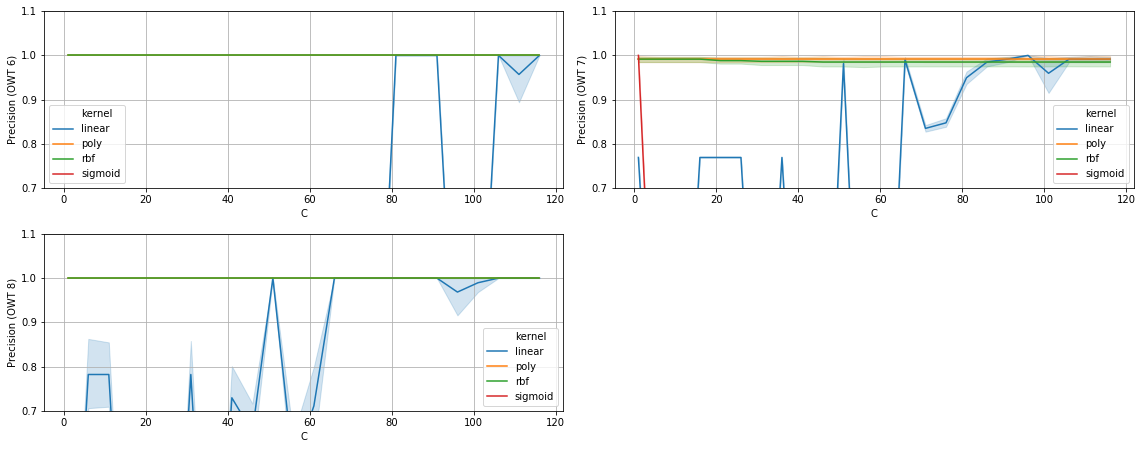

In [11]:
plt.figure(figsize=(16, 9))
i = 1
for x in ['OWT 6', 'OWT 7', 'OWT 8']:
    ax = plt.subplot(3, 2, i)
    sns.lineplot(x='C',
                 y=x,
                 hue='kernel',
                 data=precision_report,
                 ax=ax)
    ax.set_ylim(0.7,1.1)
    ax.set_ylabel('Precision (' + x + ')')
    ax.grid()
    i = i + 1

plt.tight_layout()

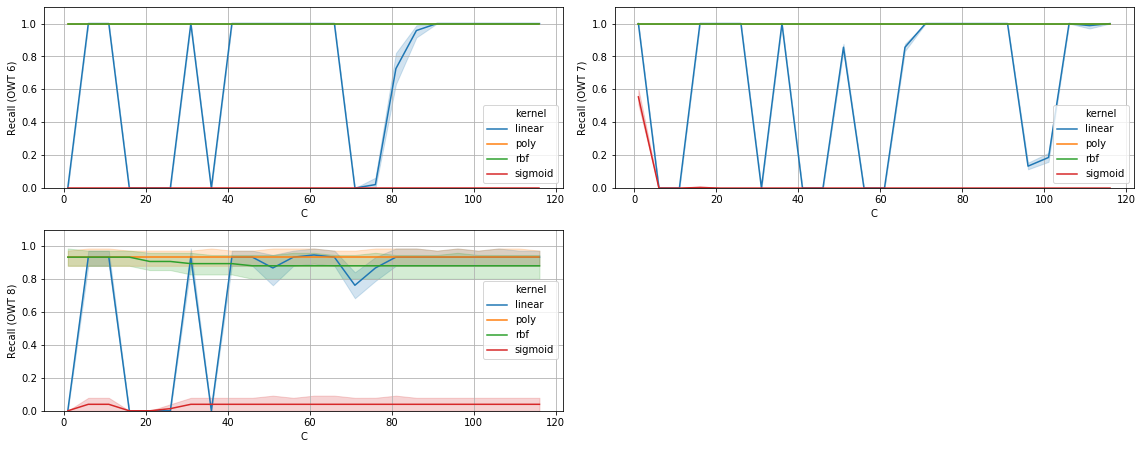

In [12]:
plt.figure(figsize=(16, 9))
i = 1
for x in ['OWT 6', 'OWT 7', 'OWT 8']:
    ax = plt.subplot(3, 2, i)
    sns.lineplot(x='C',
                 y=x,
                 hue='kernel',
                 data=recall_report,
                 ax=ax)
    ax.set_ylim(0,1.1)
    ax.set_ylabel('Recall (' + x + ')')
    ax.grid()
    i = i + 1

plt.tight_layout()

# 4 Optimal parameters
<br>
Analyzing the graphs above we can conclude that:
<br>
1. Sigmoid kernel is not applicable. Maybe it could be adjusting its parameters. However, other kernels showed satisfactory estimates. Thus, It is unnecessary trying to adjust Sigmoid parameters.
<br>
2. Linear kernel showed acceptable results in both accuracy, precision, and recall in higher C values.
<br>
3. Polynomial showed the good results.
<br>
4. RBF showed the acceptable results, for both, shape and intensity classification.

Therefore, for training the shape classification, the kernel must be linear with C of 50, while the intensity classification must also be linear and C of 116.
<br>
The linear kernels with high C was used instead of rbf and polynomial with low C because the linear performs better in the probability estimations (See SVM Classifier docs).